In [14]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
plt.style.use('fivethirtyeight')

%config InlineBackend.figure_format = 'svg'

**t-SNE**

(t-distributed stochastic neighbor embedding)

C помощью t-SNE можно снижать размерность данных, что позволяет визуализировать многомерные данные в 2D или 3D графике.

Если объекты в выборке имеют большое количество признаков, то можно получить представление о них, преобразовав данные с помощью алгоритма t-SNE.

В частности, можно увидеть возможность разделения объектов на кластеры, определить подходящее их число, а также получить представление о качестве разбиения на кластеры.

In [15]:
from keras.datasets import boston_housing

In [16]:
boston = pd.read_csv('BostonHousing.csv')

Загрузим данные о недвижимости

In [17]:
(X_train, y_train), (X_test, y_test) = boston_housing.load_data()

In [18]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((404, 13), (102, 13), (404,), (102,))

Масштабирование признаков

In [19]:
from sklearn.preprocessing import StandardScaler

In [20]:
scaler = StandardScaler()

In [21]:
X_train_scaled = scaler.fit_transform(X_train)

In [22]:
X_test_scaled = scaler.transform(X_test)

In [23]:
X_train_scaled = pd.DataFrame(X_train_scaled, columns=boston.columns[:-1])

In [24]:
X_test_scaled = pd.DataFrame(X_test_scaled, columns=boston.columns[:-1])

Применение t-SNE

In [25]:
from sklearn.manifold import TSNE

In [26]:
tsne = TSNE(n_components=2, learning_rate=150, random_state=100)

In [27]:
X_train_tsne = tsne.fit_transform(X_train_scaled)

In [28]:
X_train_tsne

array([[-4.85570192e-01,  7.48847771e+00],
       [-2.96936245e+01,  1.37468767e+01],
       [ 3.65144691e+01, -3.09825087e+00],
       [-1.22826586e+01,  4.67385292e+00],
       [ 3.09278736e+01, -3.41012359e+00],
       [-7.64147615e+00,  4.40584660e+00],
       [ 3.26835556e+01, -8.05416965e+00],
       [ 5.27413797e+00, -5.36765575e+00],
       [ 4.12509632e+00, -6.60966969e+00],
       [ 1.11746721e+01,  9.72234488e-01],
       [ 3.30050659e+01, -5.20338821e+00],
       [ 4.06857910e+01, -8.35663605e+00],
       [-7.85889006e+00, -9.41122547e-02],
       [ 3.13906956e+01, -2.64317894e+00],
       [ 9.29708481e+00,  4.60618639e+00],
       [ 3.93504219e+01, -1.11701841e+01],
       [ 2.28912849e+01, -7.45439434e+00],
       [-2.78085327e+01,  1.18497820e+01],
       [-2.80011425e+01,  1.11654282e+01],
       [-8.66353232e-03,  3.77166080e+00],
       [ 4.08099060e+01, -1.07791166e+01],
       [-3.11423492e+01,  1.05982780e+01],
       [-2.99091225e+01,  1.17210140e+01],
       [-1.

In [29]:
X_train_tsne.shape

(404, 2)

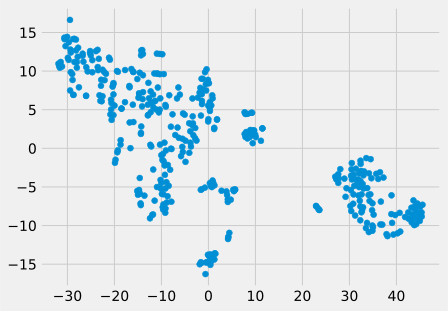

In [30]:
plt.scatter(X_train_tsne[:, 0], X_train_tsne[:, 1])
plt.show()

Разобьем данные на 2 кластера

In [31]:
from sklearn.cluster import KMeans

In [32]:
kmeans = KMeans(n_clusters=2)

In [33]:
labels_train = kmeans.fit_predict(X_train_scaled)

In [34]:
pd.value_counts(labels_train)

/var/folders/4m/n9xjjgns0d3g3fv4nnp_9zz40000gn/T/ipykernel_39813/3600805602.py:1: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  pd.value_counts(labels_train)


0    264
1    140
Name: count, dtype: int64

In [35]:
labels_test = kmeans.predict(X_test_scaled)

График t-SNE с известными лейблами

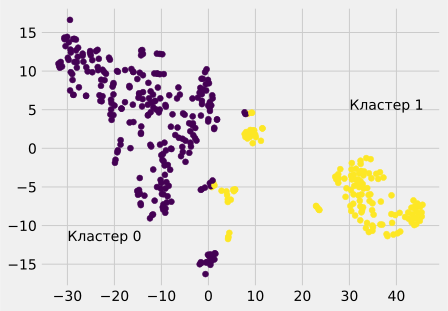

In [36]:
plt.scatter(X_train_tsne[:, 0], X_train_tsne[:, 1], c=labels_train)
plt.text(-30, -12, 'Кластер 0')
plt.text(30, 5, 'Кластер 1')
plt.show()

Посмотрим на данные, расположенные в разных кластерах

In [37]:
y_train.mean()

np.float64(22.395049504950492)

In [38]:
y_train[labels_train==0].mean()

np.float64(25.536363636363635)

In [39]:
y_train[labels_train==1].mean()

np.float64(16.47142857142857)

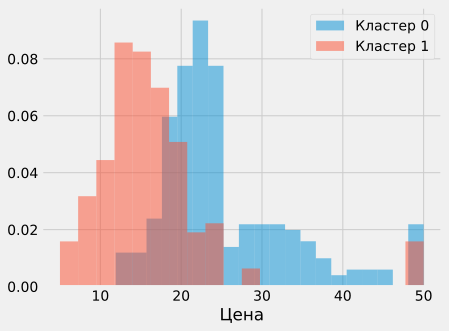

In [40]:
plt.hist(y_train[labels_train==0], bins=20, density=True, alpha=0.5)
plt.hist(y_train[labels_train==1], bins=20, density=True, alpha=0.5)
plt.legend(['Кластер 0', 'Кластер 1'])
plt.xlabel('Цена')
plt.show()

**Использование информации, полученной с помощью t-SNE в моделях**

Базовая модель предсказания цены на недвижимость (до разделения на кластеры)

In [41]:
from sklearn.linear_model import LinearRegression

In [42]:
lr = LinearRegression()

In [43]:
lr.fit(X_train_scaled, y_train)

LinearRegression()

In [44]:
y_test_pred = lr.predict(X_test_scaled)

In [45]:
from sklearn.metrics import r2_score

In [46]:
r2_score(y_test, y_test_pred)

0.7213535934621553

Две модели, построенные на объектах из разных кластеров

In [47]:
# 1я модель - на объектах из Кластера 0
lr.fit(X_train_scaled.loc[labels_train==0, :], y_train[labels_train==0])

y_test_pred_0 = lr.predict(X_test_scaled.loc[labels_test==0, :])

r2_score(y_test[labels_test==0], y_test_pred_0)

0.8475368365389074

In [48]:
# 2я модель - на объектах из Кластера 1
lr.fit(X_train_scaled.loc[labels_train==1, :], y_train[labels_train==1])

y_test_pred_1 = lr.predict(X_test_scaled.loc[labels_test==1, :])

r2_score(y_test[labels_test==1], y_test_pred_1)

0.635560379371884

In [49]:
# Объединение известных правильных ответов по объектам из двух кластеров
y_test_all = np.hstack([y_test[labels_test==0], y_test[labels_test==1]])

In [50]:
# Объединение предсказанных ответов по объектам из двух кластеров
y_test_pred_all = np.hstack([y_test_pred_0, y_test_pred_1])

In [51]:
# R2 по всем объектам тестовой выборки
r2_score(y_test_all, y_test_pred_all)

0.8483332987894504